In [ ]:
!pip install -qU diffusers transformers huggingface_hub compel

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Prompt techniques

The best prompts are detailed, specific, and well-structured to help the model realize our vision.

## Prompting engineering

Tips for writing a good prompt:
1. What is the image **medium**? Is it a photo, a painting, a 3D illustration, or something else?
2. What is the image **subject**? Is it a person, animal, object, or scene?
3. What **details** would we like to see in the image? For example, what is the lighting like? What is the vibe and aesthetic? What kind of art or illustration style are we looking for? The more specific and precise words we use, the better the model will understand what we want to generate.

In [ ]:
from diffusers import StableDiffusionXLPipeline
import torch

pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to('cuda')

In [ ]:
prompt = "A photo of a banana-shaped couch in a living room"

generator = torch.Generator('cuda').manual_seed(111)

image = pipeline(
    prompt,
    generator=generator,
).images[0]
image

In [ ]:
prompt = "A vibrant yellow banana-shaped couch sits in a cozy living room, its curve cradling a pile of colorful cushions. on the wooden floor, a patterned rug adds a touch of eclectic charm, and a potted plant sits in the corner, reaching towards the sunlight filtering through the windows"

image = pipeline(
    prompt,
    generator=generator,
).images[0]
image

## Prompt enhancing with GPT2

Prompt enhancing is a technique for quickly improving prompt quality without spending too much effort constructing one. It uses a model like GPT2 pretrained on Stable Diffusion text prompts to automatically enrich a prompt with additional important keywords to generate high-quality images.

The technique works by curating a list of specific keywords and forcing the model to generate those words to enhance the original prompt.

We start by defining certain styles and a list of words to enhance a prompt with:

In [1]:
import torch
from transformers import (
    GenerationConfig, GPT2LMHeadModel, GPT2Tokenizer,
    LogitsProcessor, LogitsProcessorList
)
from diffusers import StableDiffusionXLPipeline

styles = {
    "cinematic": "cinematic film still of {prompt}, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain",
    "anime": "anime artwork of {prompt}, anime style, key visual, vibrant, studio anime, highly detailed",
    "photographic": "cinematic photo of {prompt}, 35mm photograph, film, professional, 4k, highly detailed",
    "comic": "comic of {prompt}, graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
    "lineart": "line art drawing {prompt}, professional, sleek, modern, minimalist, graphic, line art, vector graphics",
    "pixelart": " pixel-art {prompt}, low-res, blocky, pixel art style, 8-bit graphics",
}

words = [
    "aesthetic", "astonishing", "beautiful", "breathtaking", "composition", "contrasted", "epic", "moody", "enhanced",
    "exceptional", "fascinating", "flawless", "glamorous", "glorious", "illumination", "impressive", "improved",
    "inspirational", "magnificent", "majestic", "hyperrealistic", "smooth", "sharp", "focus", "stunning", "detailed",
    "intricate", "dramatic", "high", "quality", "perfect", "light", "ultra", "highly", "radiant", "satisfying",
    "soothing", "sophisticated", "stylish", "sublime", "terrific", "touching", "timeless", "wonderful", "unbelievable",
    "elegant", "awesome", "amazing", "dynamic", "trendy",
]

Load a GPT2 tokenizer and model from the `Gustavosta/MagicPrompt-Stable-Diffusion` checkpoint because this specific checkpoint is trained to generate prompts to enhance the prompt.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('Gustavosta/MagicPrompt-Stable-Diffusion')
model = GPT2LMHeadModel.from_pretrained(
    'Gustavosta/MagicPrompt-Stable-Diffusion',
    torch_dtype=torch.float16,
).to('cuda')
model.eval()

In [3]:
word_pairs = ['highly detailed', 'high quality', 'enhanced quality', 'perfect composition', 'dynamic light']

def find_and_order_pairs(s, pairs):
    words = s.split()
    found_pairs = []

    for pair in pairs:
        pair_words = pair.split()
        if pair_words[0] in words and pair_words[1] in words:
            found_pairs.append(pair)
            words.remove(pair_words[0])
            words.remove(pair_words[1])

    for word in words[:]:
        for pair in pairs:
            if word in pair.split():
                words.remove(word)
                break

    ordered_pairs = ", ".join(found_pairs)
    remaining_s = ", ".join(words)

    return ordered_pairs, remaining_s

Then we implement a custom `LogitsProcessor` class that assigns tokens in the `words` list a value of 0 and assigns tokens not in the `words` list a negative value so they are not picked during generation. This way, generation is biased towards words in the `words` list. After a word from the list is used, it is also assigned a negative value so it is not picked again.

In [4]:
class CustomLogitsProcessor(LogitsProcessor):
    def __init__(self, bias):
        super().__init__()
        self.bias = bias

    def __call__(self, input_ids, scores):
        if len(input_ids.shape) == 2:
            last_token_id = input_ids[0, -1]
            self.bias[last_token_id] = -1e10
        return scores + self.bias


word_ids = [tokenizer.encode(word, add_prefix_space=True)[0] for word in words]
bias = torch.full((tokenizer.vocab_size,), -float('Inf')).to('cuda')
bias[word_ids] = 0

processor = CustomLogitsProcessor(bias)
processor_list = LogitsProcessorList([processor])

Combine the prompt and the `cinematic` style prompt defined in the `styles` dictionary:

In [5]:
prompt = "a cat basking in the sun on a roof in Turkey"
style = "cinematic"

prompt = styles[style].format(prompt=prompt)
prompt

'cinematic film still of a cat basking in the sun on a roof in Turkey, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain'

In [6]:
inputs = tokenizer(prompt, return_tensors='pt').to('cuda')
token_count = inputs['input_ids'].shape[1]
max_new_tokens = 50 - token_count

generation_config = GenerationConfig(
    penalty_alpha=0.7,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.eos_token_id,
    pad_token=model.config.pad_token_id,
    do_sample=True,
)

with torch.no_grad():
    generated_ids = model.generate(
        input_ids=inputs['input_ids'],
        attention_mask=inputs['attention_mask'],
        max_new_tokens=max_new_tokens,
        generation_config=generation_config,
        logits_processor=processor_list,
    )

Then we can combine the input prompt and the generated prompt.

In [7]:
output_tokens = [
    tokenizer.decode(generated_id, skip_special_tokens=True)
    for generated_id in generated_ids
]
input_part = output_tokens[0][: len(prompt)]
generated_part = output_tokens[0][len(prompt) :]
pairs, words = find_and_order_pairs(generated_part, word_pairs)

formatted_generated_part = pairs + ', ' + words
enhanced_prompt = input_part + ', ' + formatted_generated_part
enhanced_prompt

'cinematic film still of a cat basking in the sun on a roof in Turkey, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain, high quality, sharp, focus, ultra, intricate, stunning, amazing'

In [8]:
generated_part

' quality sharp focus ultra high detailed intricate stunning amazing'

In [9]:
pairs

'high quality'

In [10]:
words

'sharp, focus, ultra, intricate, stunning, amazing'

Finally, we load a pipeline and the offset noise LoRA with a low weight to generate an image with the enhanced prompt.

In [ ]:
pipeline = StableDiffusionXLPipeline.from_pretrained(
    'RunDiffusion/Juggernaut-XL-v9',
    torch_dtype=torch.float16,
    variant='fp16'
).to('cuda')

pipeline.load_lora_weights(
    'stabilityai/stable-diffusion-xl-base-1.0',
    weight_name='sd_xl_offset_example-lora_1.0.safetensors',
    adapter_name='offset'
)
pipeline.set_adapters(['offset'], adapter_weights=[0.2])

  0%|          | 0/25 [00:00<?, ?it/s]

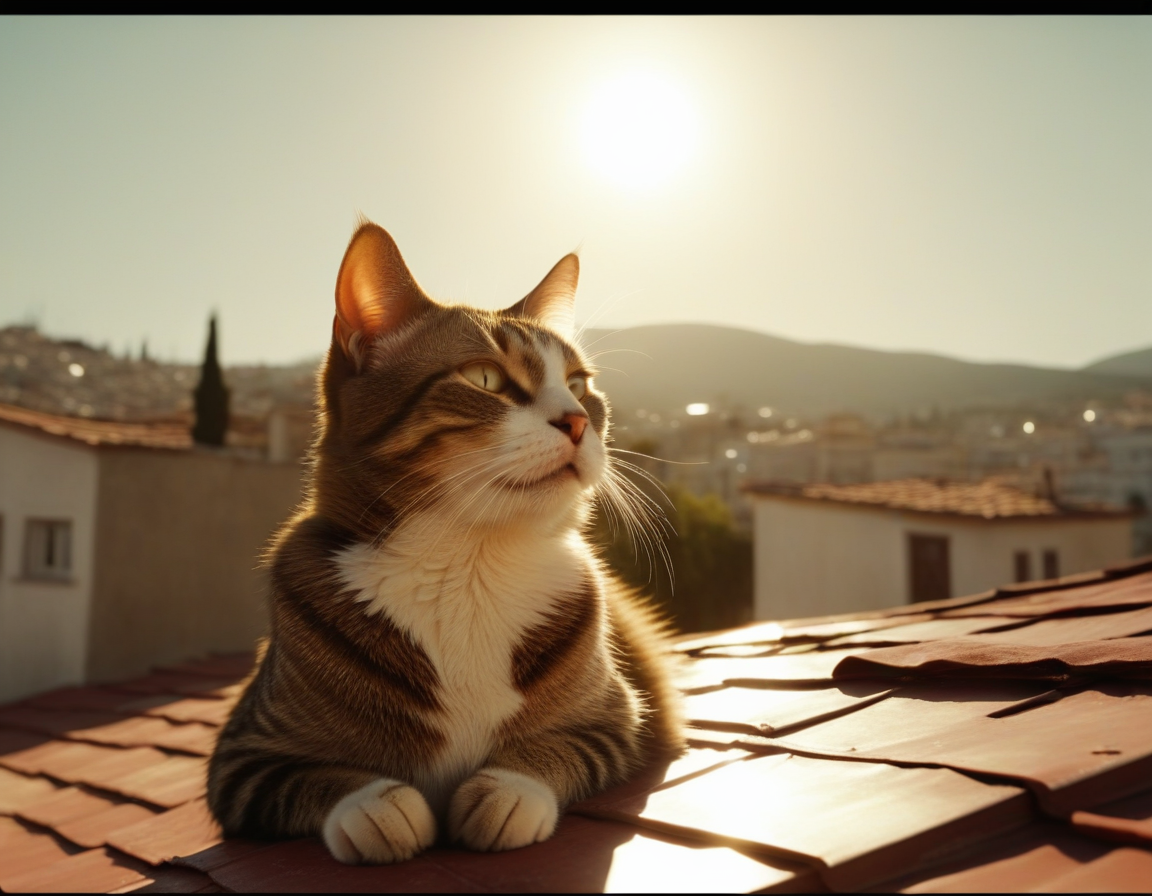

In [12]:
image = pipeline(
    enhanced_prompt,
    width=1152,
    height=896,
    guidance_scale=7.5,
    num_inference_steps=25,
).images[0]
image

## Prompt weighting

Prompt weighting provides a way to emphasize or de-emphasize certain parts of a prompt, allowing for more control over the generated image. A prompt can include several concepts, which gets turned into contextualized text embeddings. The embeddings are used by the model to condition its cross-attention layers to generate an image.

Prompt weighting works by increasing or decreasing the scale of the text embedding vector that corresponds to its concept in the prompt because we may not necessarily want the model to focus on all conecpts equally.

In this example, we generate an image with the promnpt `"a red cat playing with a ball"` using the `StableDiffusionPipeline`:

In [ ]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4',
    use_safetensors=True,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to('cuda')

  0%|          | 0/20 [00:00<?, ?it/s]

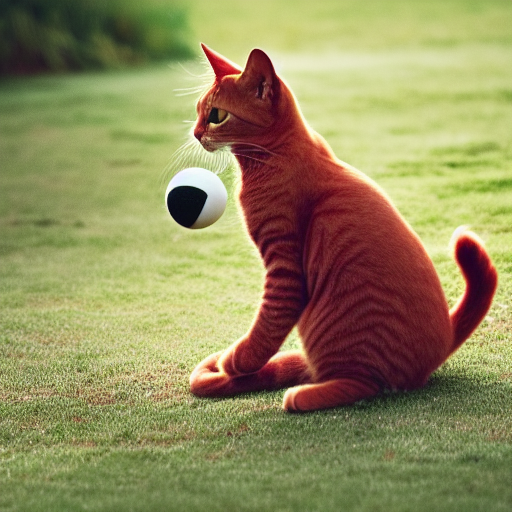

In [15]:
prompt = "a red cat playing with a ball"
generator = torch.Generator('cpu').manual_seed(111)

image = pipe(
    prompt,
    generator=generator,
    num_inference_steps=20,
).images[0]
image

### Weighting

In [16]:
from compel import Compel

compel_proc = Compel(
    tokenizer=pipe.tokenizer,
    text_encoder=pipe.text_encoder
)

compel uses `+` and `-` to increase or decrease the weight of a word in the prompt.

  0%|          | 0/20 [00:00<?, ?it/s]

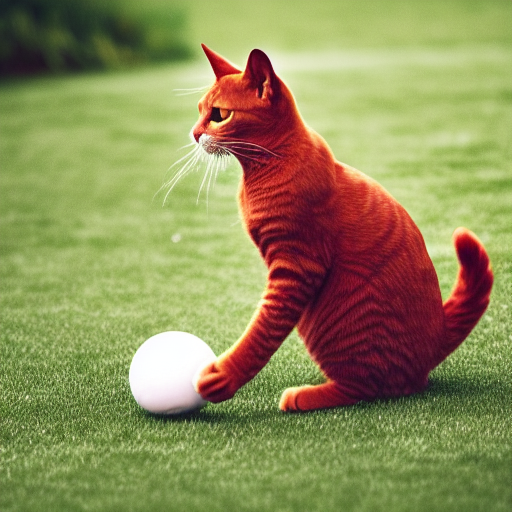

In [17]:
prompt = "a red cat playing with a ball++"

prompt_embeds = compel_proc(prompt)
generator = torch.manual_seed(111)

image = pipe(
    prompt_embeds=prompt_embeds,
    generator=generator,
    num_inference_steps=20
).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

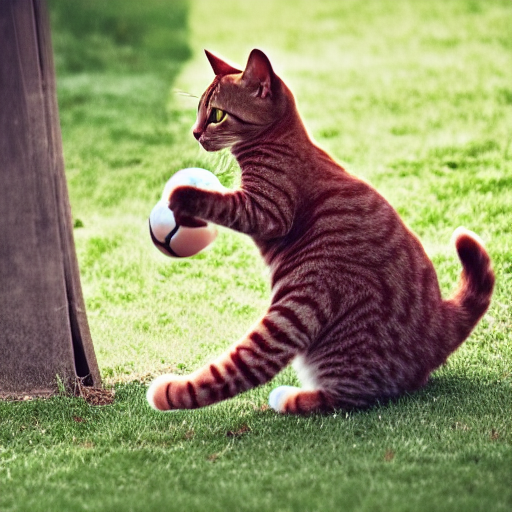

In [18]:
prompt = "a red------- cat playing with a ball"

prompt_embeds = compel_proc(prompt)
generator = torch.manual_seed(111)

image = pipe(
    prompt_embeds=prompt_embeds,
    generator=generator,
    num_inference_steps=20
).images[0]
image

  0%|          | 0/20 [00:00<?, ?it/s]

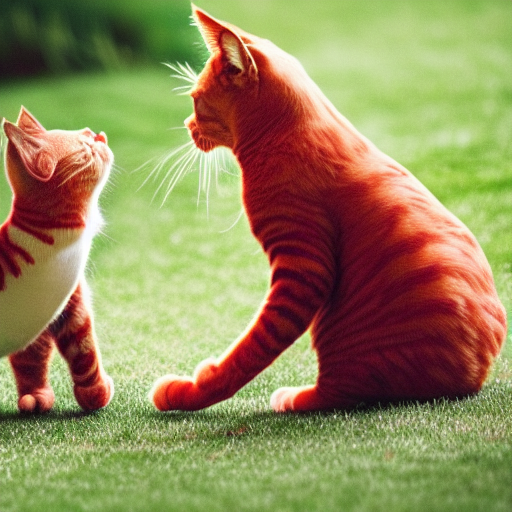

In [19]:
prompt = "a red cat++ playing with a ball----"

prompt_embeds = compel_proc(prompt)
generator = torch.manual_seed(111)

image = pipe(
    prompt_embeds=prompt_embeds,
    generator=generator,
    num_inference_steps=20
).images[0]
image

### Blending

We can also create a weighted *blend* of prompts by adding `.blend()` to a list of prompts and passing it some weights.

  0%|          | 0/20 [00:00<?, ?it/s]

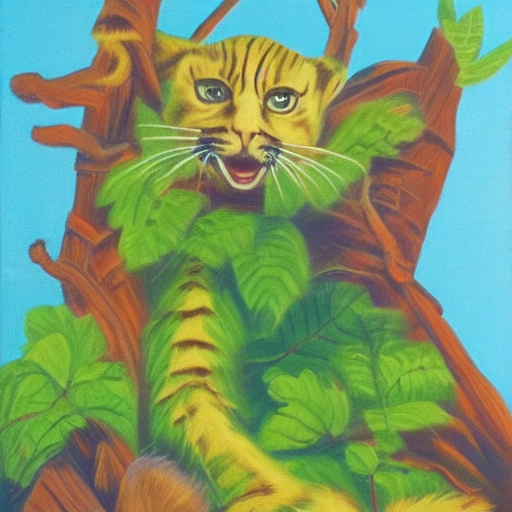

In [20]:
prompt_embeds = compel_proc(
    '("a red cat playing with a ball", "jungle").blend(0.7, 0.8)'
)
generator = torch.Generator('cuda').manual_seed(111)

image = pipe(
    prompt_embeds=prompt_embeds,
    generator=generator,
    num_inference_steps=20
).images[0]
image

### Conjunction

A conjunction diffuses each prompt independently and concatenates their results by their weighted sum.

  0%|          | 0/20 [00:00<?, ?it/s]

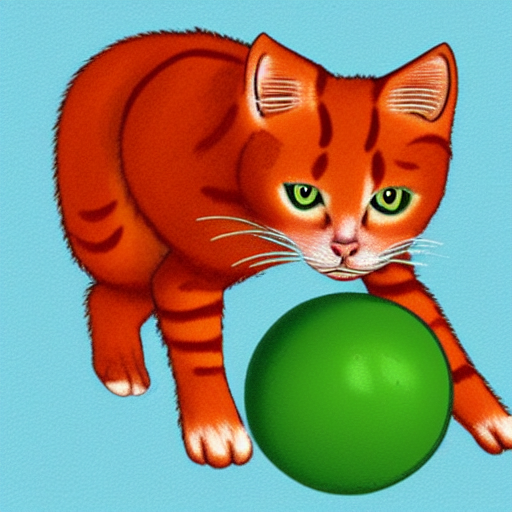

In [21]:
prompt_embeds = compel_proc(
    '["a red cat", "playing with a", "ball"].and()'
)
generator = torch.Generator('cuda').manual_seed(111)

image = pipe(
    prompt_embeds=prompt_embeds,
    generator=generator,
    num_inference_steps=20
).images[0]
image

### Textual inversion

Textual inversion is a technique for learning a specific concept from some images which we can use to generate new images conditioned on that concept.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from compel import Compel, DiffusersTextualInversionManager

pipe = StableDiffusionPipeline.from_pretrained(
    'stable-diffusion-v1-5/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant='fp16'
).to('cuda')
pipe.load_textual_inversion('sd-concepts-library/midjourney-style')

Compel provides a `DiffusersTextualInversionManager` class to simplify prompt weighting with textual inversion

In [2]:
textual_inversion_manager = DiffusersTextualInversionManager(pipe)
compel_proc = Compel(
    tokenizer=pipe.tokenizer,
    text_encoder=pipe.text_encoder,
    textual_inversion_manager=textual_inversion_manager,
)

Now we can incorporate the concept to condition a prompt with using the `<concept>` syntax:

  0%|          | 0/50 [00:00<?, ?it/s]

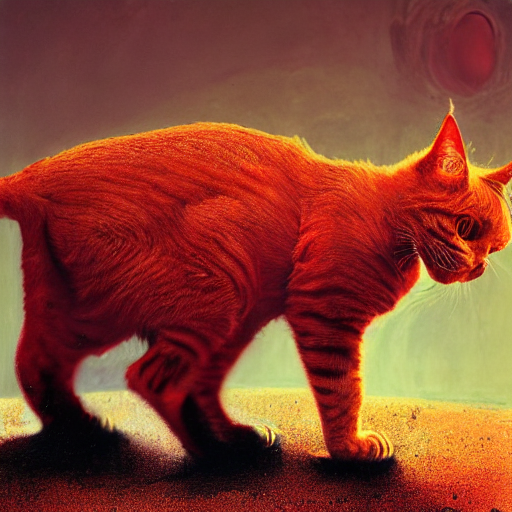

In [4]:
prompt_embeds = compel_proc('("A red cat++ playing with a ball <midjourney-style>")')

image = pipe(
    prompt_embeds=prompt_embeds,
    num_inference_steps=50
).images[0]
image

### DreamBooth

`DreamBooth` is a technique for generating contextualized images of a subject given just a few images of the subject to train on. DreamBooth trains the full model, unlike the textual inversion only fine-tunes the text embeddings.

In [ ]:
import torch
from diffusers import DiffusionPipeline, UniPCMultistepScheduler
from compel import Compel

pipe = DiffusionPipeline.from_pretrained(
    'sd-dreambooth-library/dndcoverart-v1',
    torch_dtype=torch.float16
).to('cuda')
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

  0%|          | 0/50 [00:00<?, ?it/s]

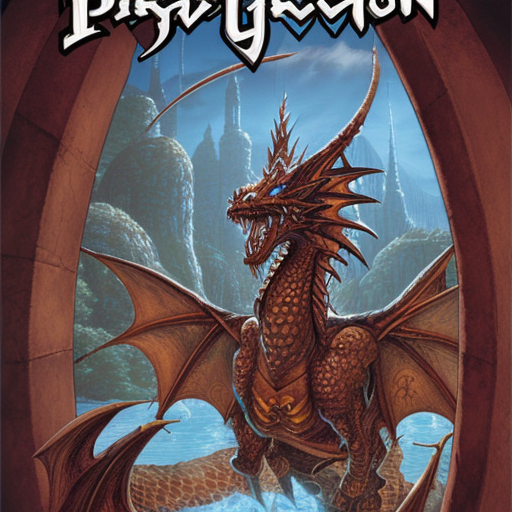

In [7]:
compel_proc = Compel(
    tokenizer=pipe.tokenizer,
    text_encoder=pipe.text_encoder
)

prompt_embeds = compel_proc(
    '("magazine cover of a dndcoverart dragon, high quality, intricate details, larry elmore art style").and()'
)

image = pipe(prompt_embeds=prompt_embeds).images[0]
image

### Stable Diffusion XL

SDXL has two tokenizers and text encoders. We should pass both tokenizers and encoders to the `Compel` class.

In [ ]:
from compel import Compel, ReturnedEmbeddingsType
from diffusers import DiffusionPipeline
from diffusers.utils import make_image_grid
import torch

pipeline = DiffusionPipeline.from_pretrained(
  "stabilityai/stable-diffusion-xl-base-1.0",
  variant="fp16",
  use_safetensors=True,
  torch_dtype=torch.float16
).to("cuda")

compel = Compel(
  tokenizer=[pipeline.tokenizer, pipeline.tokenizer_2] ,
  text_encoder=[pipeline.text_encoder, pipeline.text_encoder_2],
  returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
  requires_pooled=[False, True]
)

In [3]:
# apply weights
prompt = ["a red cat playing with a (ball)1.5", "a red cat playing with a (ball)0.6"]
conditioning, pooled = compel(prompt)

# generate image
generator = [torch.Generator().manual_seed(111) for _ in range(len(prompt))]
images = pipeline(prompt_embeds=conditioning, pooled_prompt_embeds=pooled, generator=generator, num_inference_steps=30).images
make_image_grid(images, rows=1, cols=2)

Output hidden; open in https://colab.research.google.com to view.